In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import mlflow

/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
load_dotenv(find_dotenv())

os.environ["AWS_ACCESS_KEY_ID"] = os.environ.get("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.environ.get("AWS_SECRET_ACCESS_KEY")
os.environ["S3_BUCKET_NAME"] = os.environ.get("S3_BUCKET_NAME")
os.environ["S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"

RANDOM_STATE = 42

In [3]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = "sprint5"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

os.environ["MLFLOW_HTTP_REQUEST_TIMEOUT"] = "10"

# Часть 1

## Этап 1

In [12]:
uplift_fp_data = pd.read_csv('uplift_fp_data.csv') 
uplift_fp_data.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


Категоиральных колонок нет, а значит перекодирвать не нужно

In [6]:
uplift_fp_data.isnull().sum()


recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

Пропусков нет и это великлепно

## Этап 2

### EDA


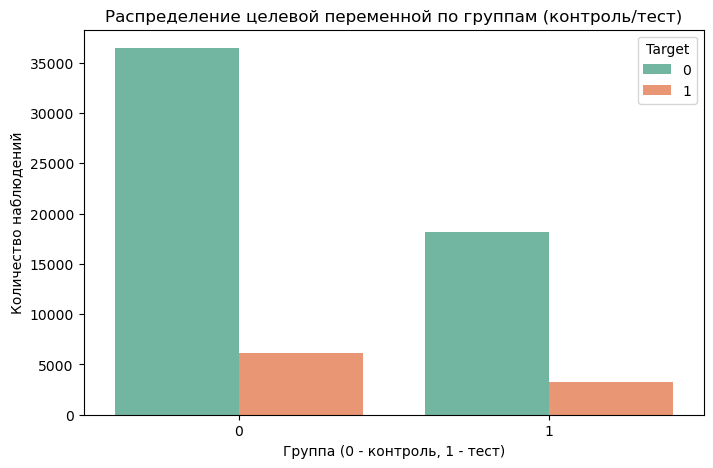

Распределение по treatment и target:


target,0,1
treatment,,
0,36457,6156
1,18149,3238



Доли целевого события в каждой группе:


target,0,1
treatment,,
0,0.856,0.144
1,0.849,0.151


In [7]:
# Проверим распределение целевой переменной между контрольной и тестовой группами
grouped = uplift_fp_data.groupby(['treatment', 'target']).size().reset_index(name='count')

# Построим barplot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=grouped,
    x='treatment',
    y='count',
    hue='target',
    palette='Set2'
)
plt.title('Распределение целевой переменной по группам (контроль/тест)')
plt.xlabel('Группа (0 - контроль, 1 - тест)')
plt.ylabel('Количество наблюдений')
plt.legend(title='Target')
plt.show()

# Также выведем абсолютные и относительные значения для контроля
print("Распределение по treatment и target:")
display(
    uplift_fp_data.groupby(['treatment', 'target']).size().unstack(fill_value=0)
)
print("\nДоли целевого события в каждой группе:")
display(
    uplift_fp_data.groupby('treatment')['target'].value_counts(normalize=True).unstack().round(3)
)


Проверим баланс классов

In [16]:
uplift_fp_data['target'].value_counts(normalize=True)

target
0    0.853219
1    0.146781
Name: proportion, dtype: float64

In [15]:
uplift_fp_data['treatment'].value_counts(normalize=True)

treatment
0    0.665828
1    0.334172
Name: proportion, dtype: float64

### **Вывод по EDA:**

- **Распределение целевой переменной (`target`) между контрольной (`treatment=0`) и тестовой (`treatment=1`) группами очень схожи.**
- **Доля целевого события составляет примерно 14–15% в обеих группах.**
- Это говорит о корректной рандомизации и отсутствии явных перекосов между группами.
- Абсолютное количество наблюдений в контрольной группе примерно в два раза больше, чем в тестовой. Это важно учитывать при дальнейшем анализе.


# Этап 2

### Проверка на статистическую значимость

Шаг 1: Разделите данные на контрольную и тестовую группы

In [7]:
control = uplift_fp_data[uplift_fp_data['treatment'] == 0]['target']
treatment = uplift_fp_data[uplift_fp_data['treatment'] == 1]['target']

Шаг 2: Анализ средних значений и стандартных отклонений

In [8]:
mean_control = np.mean(control)
std_control = np.std(control, ddof=1)

mean_treatment = np.mean(treatment)
std_treatment = np.std(treatment, ddof=1)

# Вывод
print("📊 Статистики по группам:\n")
print(f"Контрольная группа:")
print(f"  Среднее значение:           {mean_control:.4f}")
print(f"  Стандартное отклонение:     {std_control:.4f}\n")

print(f"Тестовая группа:")
print(f"  Среднее значение:           {mean_treatment:.4f}")
print(f"  Стандартное отклонение:     {std_treatment:.4f}")

📊 Статистики по группам:

Контрольная группа:
  Среднее значение:           0.1445
  Стандартное отклонение:     0.3516

Тестовая группа:
  Среднее значение:           0.1514
  Стандартное отклонение:     0.3584


#### Вывод по результатам сравнения групп

- **Среднее значение** в тестовой группе (0.1514) чуть выше, чем в контрольной (0.1445).  
- **Стандартное отклонение** также немного выше в тестовой группе (0.3584 против 0.3516), что говорит о немного большей разбросанности данных.  
- Разница в средних значениях **незначительная** — предварительно можно предположить, что эффекта почти нет, однако для окончательного вывода стоит провести статистический тест (например, t-тест для независимых выборок), чтобы проверить, является ли эта разница статистически значимой.

**Предварительный вывод:** изменений между контрольной и тестовой группой практически не наблюдается.

##### 📄 Шаг 3: Обоснование выбора статистического теста

Целевая переменная `target` является бинарной (0 или 1), поэтому сравнение между контрольной и тестовой группами фактически означает сравнение **долей откликнувшихся пользователей**.

##### Возможные тесты:
- **t-тест для независимых выборок (Welch’s t-test)** — сравнивает средние (в нашем случае — доли), допускает разные дисперсии.
- **Манна–Уитни (непараметрический тест)** — сравнивает распределения, используется если данные не нормальны.
- **Z-тест для пропорций** — также подходит, но t-тест используется чаще, так как он встроен в большинство библиотек и адаптирован под реальную дисперсию.

##### Наш подход:
1. Проверяем нормальность распределений в каждой группе с помощью **теста Шапиро–Уилка**.
2. Если обе группы нормальны (p > 0.05), используем **t-тест с поправкой на неравные дисперсии (Welch’s)**.
3. Если хотя бы одно распределение не нормальное — используем **тест Манна–Уитни**.

Таким образом, тест выбирается адаптивно и надёжно.

Шаг 4: Применяем выбранный статистический тест

In [9]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Проверка нормальности
p_shapiro_control = shapiro(control).pvalue
p_shapiro_treatment = shapiro(treatment).pvalue

print("\n📈 Проверка нормальности (тест Шапиро–Уилка):")
print(f"  Контрольная группа: p = {p_shapiro_control:.4f}")
print(f"  Тестовая группа:    p = {p_shapiro_treatment:.4f}")

# Выбор и применение теста
if p_shapiro_control > 0.05 and p_shapiro_treatment > 0.05:
    test_name = "t-тест (Welch’s)"
    stat, p_value = ttest_ind(treatment, control, equal_var=False)
else:
    test_name = "тест Манна–Уитни"
    stat, p_value = mannwhitneyu(treatment, control, alternative='two-sided')

# Вывод результата
print(f"\n🧪 Применённый тест: {test_name}")
print(f"  Статистика: {stat:.4f}")
print(f"  p-value:    {p_value:.4f}")


📈 Проверка нормальности (тест Шапиро–Уилка):
  Контрольная группа: p = 0.0000
  Тестовая группа:    p = 0.0000

🧪 Применённый тест: тест Манна–Уитни
  Статистика: 458843376.5000
  p-value:    0.0193


/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 42613.
  res = hypotest_fun_out(*samples, **kwds)
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21387.
  res = hypotest_fun_out(*samples, **kwds)


Шаг 5: Интерпретация результата

In [10]:
if p_value < 0.05:
    print("\n✅ Различия между группами статистически значимы (p < 0.05).")
else:
    print("\n❌ Различия между группами не являются статистически значимыми (p ≥ 0.05).")


✅ Различия между группами статистически значимы (p < 0.05).


#### **Вывод:**  
Хотя среднее значение в тестовой группе лишь немного выше, чем в контрольной, а разброс данных схож, статистический анализ показал, что эта разница является статистически значимой (p < 0.05), что указывает на наличие реального эффекта, а не случайного колебания.


## Построение корреляций

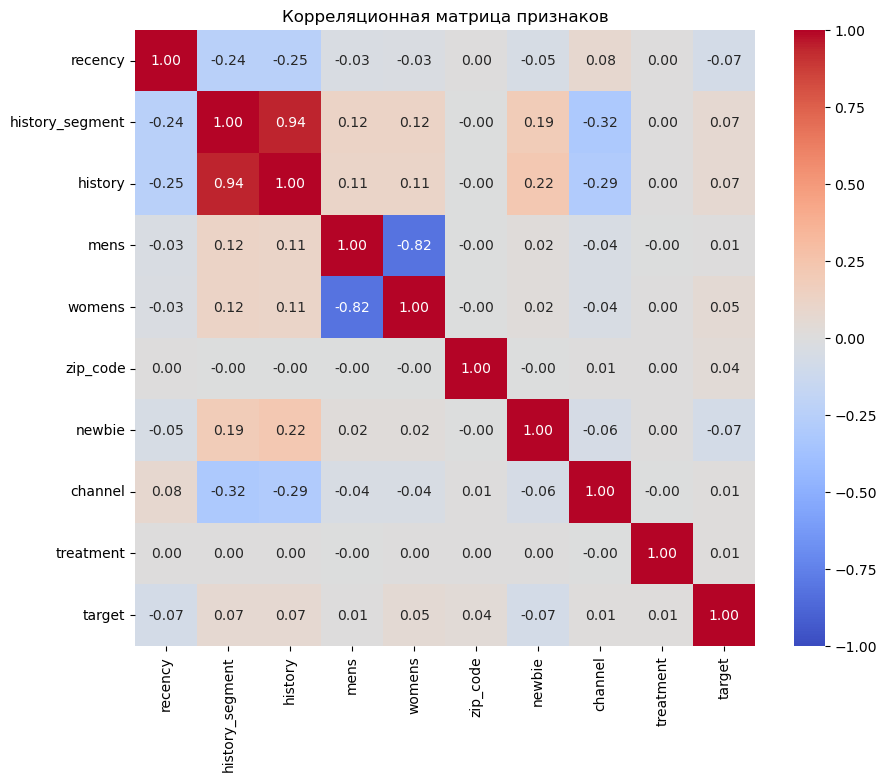

Корреляция признаков с целевой переменной (target):
history_segment    0.069734
history            0.065153
womens             0.051999
zip_code           0.037570
channel            0.010584
treatment          0.009247
mens               0.006712
newbie            -0.073924
recency           -0.074765
Name: target, dtype: float64

Корреляция признаков с переменной treatment:
target             0.009247
history_segment    0.001869
newbie             0.001416
history            0.001247
recency            0.000831
womens             0.000544
zip_code           0.000214
channel           -0.002954
mens              -0.002991
Name: treatment, dtype: float64


In [12]:
# Рассчитаем корреляционную матрицу по всем числовым признакам, включая target и treatment
corr_matrix = uplift_fp_data.corr(numeric_only=True)

# Визуализируем корреляционную матрицу с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица признаков")
plt.show()

# Посмотрим на корреляцию признаков с целевой переменной, исключая саму переменную
corr_with_target = corr_matrix['target'].drop('target').sort_values(ascending=False)
print("Корреляция признаков с целевой переменной (target):")
print(corr_with_target)

# Посмотрим на корреляцию признаков с treatment, исключая саму переменную
corr_with_treatment = corr_matrix['treatment'].drop('treatment').sort_values(ascending=False)
print("\nКорреляция признаков с переменной treatment:")
print(corr_with_treatment)


#### **Вывод по корреляционному анализу:**

- Анализ корреляции показал, что связь признаков с целевой переменной **слабая** (коэффициенты не превышают ±0.08), что указывает на отсутствие выраженной линейной зависимости. Наибольшую положительную корреляцию с целевой переменной имеют `history_segment` (0.0697) и `history` (0.0652), а наибольшую отрицательную — `recency` (-0.0748) и `newbie` (-0.0739).  

- Связь признаков с переменной `treatment` практически отсутствует (значения коэффициентов близки к нулю), что говорит об отсутствии мультиколлинеарности между фактором назначения в тест и другими признаками.  

- **Для стратификации** при формировании тестовой и контрольной групп можно использовать признаки, наиболее связанные с целевой переменной: `history_segment`, `history`, `recency`, `newbie`. Это позволит сбалансировать группы по значимым характеристикам.  

- **Признаки с минимальной информативностью** по отношению к целевой переменной и `treatment` (`channel`, `mens`, `zip_code`) можно рассматривать как кандидатов для исключения из модели или анализа, так как их вклад в прогноз и сегментацию минимален.

## Этап 3

#### **Обоснование выбора uplift-модели**
В качестве бейзлайна для uplift-моделирования используется просто CatBoostClassifier.
 
CatBoost хорошо работает с категориальными и числовыми признаками, устойчив к мультиколлинеарности и не требует сложной предобработки данных. 
Для задачи с бинарным treatment и целевой переменной CatBoostClassifier позволяет быстро получить сильную базовую модель для оценки uplift-эффекта.

### Разбиение выборки на тренировочную и тестовую

In [309]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']]
)



### Обучение выбранного бейзлайна

In [310]:
from catboost import CatBoostClassifier

# CatBoostClassifier для бейзлайна
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=RANDOM_STATE,
    verbose=100,
    allow_writing_files=False
)

# Обучаем CatBoost на тренировочных данных
catboost_model.fit(X_train, y_train)


0:	learn: 0.6451566	total: 9.4ms	remaining: 930ms
99:	learn: 0.3975504	total: 212ms	remaining: 0us


### Важность признаков представить в виде графика

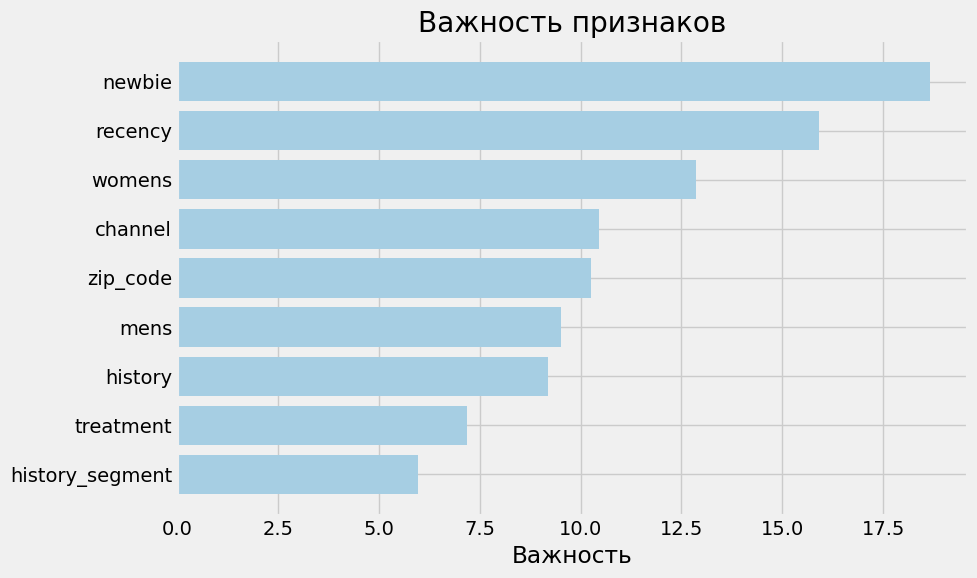

Важности признаков:
newbie: 18.6697
recency: 15.9126
womens: 12.8539
channel: 10.4479
zip_code: 10.2540
mens: 9.5058
history: 9.2048
treatment: 7.1851
history_segment: 5.9661


In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Получим важности признаков из модели CatBoost
feature_importances = catboost_model.get_feature_importance()
feature_names = X_train.columns

# Отсортируем признаки по важности
indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = feature_importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Важность признаков")
plt.barh(range(len(sorted_features)), sorted_importances[::-1], align='center')
plt.yticks(range(len(sorted_features)), sorted_features[::-1])
plt.xlabel("Важность")
plt.tight_layout()
plt.savefig("feature_importance.png", format="png")  # Сохраняем как PNG
plt.show()

# Выведем важности признаков списком
print("Важности признаков:")
for name, importance in zip(sorted_features, sorted_importances):
    print(f"{name}: {importance:.4f}")


На графике выше видно, что наибольшую важность для модели имеют следующие признаки (значения важности указаны в скобках):
 - newbie (новый клиент): 18.67
 - recency (давность последней покупки): 15.91
 - womens (пол — женский): 12.85
 - channel (канал коммуникации): 10.45
 - zip_code (почтовый индекс): 10.25
 - mens (пол — мужской): 9.51
 - history (история покупок): 9.20
 - treatment (факт воздействия): 7.19
 - history_segment (сегмент по истории): 5.97

 Наибольший вклад в предсказания модели вносит признак "newbie" (новый клиент), а также признаки, связанные с давностью последней покупки (recency) и полом клиента (womens, mens).
 Признаки "channel", "zip_code", "history" и "treatment" также оказывают заметное влияние на предсказания модели.
 Сегмент по истории ("history_segment") имеет наименьшую, но не нулевую важность.

 Это говорит о том, что статус клиента (новый или нет), его недавняя активность, а также пол и канал коммуникации — ключевые факторы для uplift-моделирования в данной задаче.
Для дальнейшего улучшения модели стоит сфокусироваться на анализе поведения новых клиентов, а также на генерации новых признаков, связанных с каналом коммуникации и историей покупок.


### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [23]:
from sklift.metrics import uplift_at_k, qini_auc_score, uplift_auc_score

def calculate_uplift(model, X_test, treatment_col='treatment'):
    
    # Копии тестовых данных
    X_treated = X_test.copy()
    X_control = X_test.copy()
    
    # Устанавливаем значения treatment
    X_treated[treatment_col] = 1
    X_control[treatment_col] = 0
    
    # Предсказания
    y_pred_treated = model.predict_proba(X_treated)[:, 1]
    y_pred_control = model.predict_proba(X_control)[:, 1]
    
    # Uplift
    uplift_vals = y_pred_treated - y_pred_control
    
    # Добавляем в копию тестовых данных
    result_df = X_test.copy()
    result_df['predicted_uplift'] = uplift_vals
    
    return result_df

def evaluate_uplift_metrics(y_true, uplift_vals, treatment, k=0.3):
    metrics = {
        "qini_auc": qini_auc_score(y_true=y_true, uplift=uplift_vals, treatment=treatment),
        "uplift_auc": uplift_auc_score(y_true=y_true, uplift=uplift_vals, treatment=treatment),
        f"uplift_at_{int(k*100)}": uplift_at_k(
            y_true=y_true, uplift=uplift_vals, treatment=treatment,
            strategy='overall', k=k
        )
    }

    return metrics

In [ ]:
X_test_uplift = calculate_uplift(catboost_model, X_test, treatment_col='treatment')

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=X_test_uplift['predicted_uplift'].values,
    treatment=X_test_uplift['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

qini_auc: 0.0574
uplift_auc: 0.0256
uplift_at_30%: 0.0387


#### 📊 Выводы по метрикам Catboost

| Метрика        | Значение  |
|:--------------:|:---------:|
| **Qini AUC**   | 0.0574    |
| **Uplift AUC** | 0.0256    |
| **Uplift@30%** | 0.03687   |

Значения метрик невысокие.

Модель неплохо различает пользователей, на которых воздействие `treatment` оказывает положительный эффект, однако потенциал для улучшения остается значительным.

**Рекомендации:**
- Продолжить работу над feature engineering
- Рассмотреть альтернативные модели (`Т-Learner`, `X-Learner` и др.)

#### Логируем в mlflow

In [ ]:
import mlflow.catboost
from mlflow.models.signature import infer_signature

RUN_NAME_CATBOOST = "uplift_baseline_catboost"
REGISTRY_MODEL_NAME = "uplift_baseline_catboost"

mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME_CATBOOST):
    # Логируем параметры модели
    mlflow.log_params(catboost_model.get_params())

    # Логируем uplift-метрики
    mlflow.log_metric("qini_auc", metrics["qini_auc"])
    mlflow.log_metric("uplift_auc", metrics["uplift_auc"])
    mlflow.log_metric("uplift_at_30", metrics["uplift_at_30"])

    mlflow.log_artifact("feature_importance.png")

    # сигнатура для модели
    signature = infer_signature(X_test, catboost_model.predict(X_test))

    # Логируем модель в MLflow
    mlflow.catboost.log_model(
        cb_model=catboost_model,
        name="uplift_model",
        registered_model_name=REGISTRY_MODEL_NAME, 
        pip_requirements="./requirements.txt",
        signature=signature
    )

2025/08/07 15:53:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/md/wzk6m8kj39v1mnc59nyt9z5m0000gn/T/tmp4yxr5uwu/model, flavor: catboost). Fall back to return ['catboost==1.2.8']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'uplift_baseline_catboost'.
2025/08/07 15:53:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: uplift_baseline_catboost, version 1
Created version '1' of model 'uplift_baseline_catboost'.


🏃 View run uplift_baseline_catboost at: http://127.0.0.1:5000/#/experiments/34/runs/13460957fab343d4bccf9431bb64f7a6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/34


# Обучение 2 моделей 

Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг

In [325]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']] 
)

### Обучение модели 1

In [326]:
from causalml.inference.meta import BaseTClassifier
from sklearn.ensemble import RandomForestClassifier

# создаём базовые модели для тестовой и контрольной групп 
treatment_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

control_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

# инициализируем T-learner
t_learner = BaseTClassifier(
    treatment_learner=treatment_model,
    control_learner=control_model,
    control_name=0,  # название контрольной группы в столбце treatment
)

# обучаем T-learner
t_learner.fit(
    X=X_train.values,  # Признаки без столбца treatment
    treatment=X_train['treatment'].values,       # Столбец с признаком воздействия
    y=y_train.values                            # Целевая переменная
)

### Получение метрик по модели 1

In [334]:
uplift_pred = t_learner.predict(X_test.values)

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=uplift_pred.squeeze(),
    treatment=X_test['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

qini_auc: 0.0607
uplift_auc: 0.0269
uplift_at_30%: 0.0344


#### 📊 Сравнение с CatBoost

| Метрика        | T-Learner | CatBoost | Δ (T − Cat) |
|:--------------:|:---------:|:--------:|:-----------:|
| **Qini AUC**   | 0.0607    | 0.0574   | +0.0033     |
| **Uplift AUC** | 0.0269    | 0.0256   | +0.0013     |
| **Uplift@30%** | 0.0344    | 0.0369   | -0.0025     |

📌 **Вывод:** T-Learner показал чуть лучше результаты по Qini AUC и Uplift AUC, но проиграл CatBoost по Uplift@30%.

#### Логируем в mlflow

In [ ]:
import joblib
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow import pyfunc

RUN_NAME = "uplift_t_learner"
REGISTRY_MODEL_NAME = "uplift_t_learner"

mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME):
    # Логируем параметры моделей
    mlflow.log_params({f"treatment__{k}": v for k, v in treatment_model.get_params().items()})
    mlflow.log_params({f"control__{k}": v for k, v in control_model.get_params().items()})

    # Логируем uplift-метрики
    mlflow.log_metric("qini_auc", metrics["qini_auc"])
    mlflow.log_metric("uplift_auc", metrics["uplift_auc"])
    mlflow.log_metric("uplift_at_30", metrics["uplift_at_30"])

    # Логируем базовые модели отдельно
    mlflow.sklearn.log_model(treatment_model, artifact_path="treatment_model")
    mlflow.sklearn.log_model(control_model, artifact_path="control_model")

    # Сохраняем T-learner как артефакт
    joblib.dump(t_learner, "t_learner.pkl")
    mlflow.log_artifact("t_learner.pkl")

    # Сигнатура — вход как при обучении (с treatment)
    signature = infer_signature(
        X_test.head(5),  
        t_learner.predict(X_test.head(5).values)
    )

    # PyFunc-обёртка для загрузки и предсказаний
    class UpliftPyFunc(pyfunc.PythonModel):
        def load_context(self, context):
            import joblib
            self.model = joblib.load(context.artifacts["t_learner"])
        def predict(self, context, model_input):
            import numpy as np
            X = model_input.values if hasattr(model_input, "values") else np.asarray(model_input)
            return self.model.predict(X)

    # Логируем единую модель в реестр
    pyfunc.log_model(
        artifact_path="uplift_model",
        python_model=UpliftPyFunc(),
        artifacts={"t_learner": "t_learner.pkl"},
        signature=signature,
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements="./requirements.txt",
    )

2025/08/08 11:08:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 11:08:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/08/08 11:08:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/08 11:08:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer

🏃 View run uplift_t_learner at: http://127.0.0.1:5000/#/experiments/34/runs/f4b628679d0949aaa177f12e2a8a086f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/34


### Обучение модели 2

In [335]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = uplift_fp_data.drop('target', axis=1)
y = uplift_fp_data['target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=uplift_fp_data[['target', 'treatment']] 
)

In [336]:
import numpy as np
import pandas as pd
from causalml.inference.meta import BaseRClassifier
from xgboost import XGBClassifier, XGBRegressor

features = uplift_fp_data.drop(columns=['target','treatment']).columns
T = X_train.treatment.values  # 1 - treatment, 0 - control
X_train = X_train[features]
y_train = y_train.values  # целевая переменная
T_test = X_test.treatment.values

outcome_learner=XGBClassifier(
    n_estimators=200,
    learning_rate=0.02,
    max_depth=6,
    random_state=RANDOM_STATE,
    verbosity=0
)

effect_learner=XGBRegressor(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=6,
    random_state=RANDOM_STATE,
    verbosity=0
)

propensity_learner=XGBClassifier(
    n_estimators=200,
    learning_rate=0.02,
    max_depth=6,
    random_state=RANDOM_STATE,
    verbosity=0
)


# инициализируем R-learner с моделями XGBoost
# outcome_learner — модель для предсказания исхода без учёта воздействия
# effect_learner — модель для оценки эффекта воздействия
# propensity_learner — модель для оценки вероятности получения воздействия
r_learner = BaseRClassifier(
    outcome_learner=outcome_learner,
    effect_learner=effect_learner,
    propensity_learner=propensity_learner
)

# инициализируем массив для propensity score
e_x = np.zeros(len(X_train))
T_test = X_test.treatment.values

# обучаем модель для оценки propensity score
model_e = XGBClassifier(n_estimators=200, 
                        learning_rate=0.02, 
                        max_depth=6, 
                        random_state=42, 
                        verbosity=0)
model_e.fit(X_train, T)
e_x = model_e.predict_proba(X_train)[:, 1]

# обучаем модель R-learner
r_learner.fit(
    X=X_train,
    treatment=T,
    y=y_train,
    p=e_x,
    verbose=True
)


2025-08-08 13:52:20,093 INFO: generating out-of-fold CV outcome estimates
2025-08-08 13:52:22,002 INFO: training the treatment effect model for 1 with R-loss


### Получение метрик по модели 2

In [338]:
uplift_pred = r_learner.predict(X_test.drop(columns=['treatment']).values)

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=uplift_pred.squeeze(),
    treatment=X_test['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

qini_auc: 0.0520
uplift_auc: 0.0233
uplift_at_30%: 0.0229


#### 📊 Сравнение метрик

| Метрика        | T-Learner | R-Learner | CatBoost | Лидер |
|:--------------:|:---------:|:---------:|:--------:|:-----:|
| **Qini AUC**   | 0.0607    | 0.0520    | 0.0574   | T     |
| **Uplift AUC** | 0.0269    | 0.0233    | 0.0256   | T     |
| **Uplift@30%** | 0.0344    | 0.0229    | 0.0369   | Cat   |

📌 **Вывод:**  
- По **Qini AUC** и **Uplift AUC** лучше всего показал себя **T-Learner**.  
- По **Uplift@30%** лидер — **CatBoost**.  
- **R-Learner** на этих данных оказался слабее обоих.


#### Логируем в mlflow

In [ ]:
from pathlib import Path

import joblib
import mlflow
from mlflow import pyfunc
from mlflow.models.signature import infer_signature

RUN_NAME = "uplift_r_learner"
REGISTRY_MODEL_NAME = "uplift_r_learner"

ART_R_LEARNER = "r_learner.pkl"
ART_FEATURES = "feature_names.json"
ART_XGB_E = "model_e"

# feature_names может быть pd.Index / np.ndarray / list -> приводим к list и убираем 'treatment'
feature_names_list = [c for c in list(feature_names) if c != "treatment"]


mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME):
    # логируем параметры бейзлайн-моделей
    mlflow.log_params({f"outcome__{k}": v for k, v in outcome_learner.get_params().items()})
    mlflow.log_params({f"effect__{k}": v for k, v in effect_learner.get_params().items()})
    mlflow.log_params({f"propensity__{k}": v for k, v in propensity_learner.get_params().items()})

    # логируем метрики uplift
    mlflow.log_metrics({
        "qini_auc": float(metrics["qini_auc"]),
        "uplift_auc": float(metrics["uplift_auc"]),
        "uplift_at_30": float(metrics["uplift_at_30"]),
    })

    # логируем отдельную модель (например, XGBoost эффекта)
    mlflow.xgboost.log_model(model_e, artifact_path=ART_XGB_E)

    # сохраняем R-learner и артефакты локально и логируем их
    joblib.dump(r_learner, ART_R_LEARNER)
    mlflow.log_artifact(ART_R_LEARNER)
    mlflow.log_artifact(ART_FEATURES)

    sig_input = X_test[feature_names_list].head(5)
    sig_output = r_learner.predict(sig_input.values)
    signature = infer_signature(sig_input, sig_output)

    # --- PyFunc-обёртка ---
    class UpliftRPyFunc(pyfunc.PythonModel):
        def load_context(self, context):
            import json, joblib
            self.model = joblib.load(context.artifacts["r_learner"])
            self.feature_names = json.loads(Path(context.artifacts["feature_names"]).read_text(encoding="utf-8"))

        def _extract_X(self, model_input):
            import numpy as np
            import pandas as pd

            # если DataFrame: проверяем наличие всех колонок и упорядочиваем
            if isinstance(model_input, pd.DataFrame):
                missing = [c for c in self.feature_names if c not in model_input.columns]
                if missing:
                    raise ValueError(f"Отсутствуют признаки: {missing}")
                return model_input[self.feature_names].to_numpy()

            # если Series: единичный объект
            if isinstance(model_input, pd.Series):
                missing = [c for c in self.feature_names if c not in model_input.index]
                if missing:
                    raise ValueError(f"Отсутствуют признаки: {missing}")
                return model_input[self.feature_names].to_numpy().reshape(1, -1)

            # иначе считаем, что это уже numpy-матрица корректной формы
            X = np.asarray(model_input)
            return X

        def predict(self, context, model_input):
            X = self._extract_X(model_input)
            return self.model.predict(X)

    # --- Логируем единую модель в реестр ---
    pyfunc.log_model(
        artifact_path="uplift_model",
        python_model=UpliftRPyFunc(),
        artifacts={
            "r_learner": ART_R_LEARNER,
            "feature_names": ART_FEATURES,
        },
        signature=signature,
        input_example=sig_input,  
        registered_model_name=REGISTRY_MODEL_NAME,
        pip_requirements="./requirements.txt",
    )

2025/08/08 11:35:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [11:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/08/08 11:35:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

🏃 View run uplift_r_learner at: http://127.0.0.1:5000/#/experiments/35/runs/42f473d147804ea9a954260259a2cef9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/35


#### 📊 Метрики T-Learner

| Метрика        | Значение |
|:--------------:|:--------:|
| **Qini AUC**   | 0.0607   |
| **Uplift AUC** | 0.0269   |
| **Uplift@30%** | 0.0328   |

Качество модели низкое — способность выявлять пользователей с положительным эффектом воздействия близка к случайной.

#### 📌 Рекомендации
- Улучшить признаки (**feature engineering**).
- Проверить фичи отдельно в treatment и control.
- Протестировать другие методы: X-Learner, R-Learner.

Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

# Часть 2

## Этап 1

Возьмем базовый Catboost и погираемся со стртификацией

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


# Комбинируем значимые признаки в одну страту
strata = (
    uplift_fp_data['target'].astype(int).astype(str) + '_' +
    uplift_fp_data['treatment'].astype(int).astype(str) + '_' +
    uplift_fp_data['newbie'].astype(int).astype(str) + '_' +
    uplift_fp_data['womens'].astype(int).astype(str)
)

In [31]:
X = uplift_fp_data.drop(columns=['target'])
y = uplift_fp_data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=strata
)

In [350]:
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=RANDOM_STATE,
    verbose=100,
    allow_writing_files=False
)

# Обучаем CatBoost на тренировочных данных
catboost_model.fit(X_train, y_train)

X_test_uplift = calculate_uplift(catboost_model, X_test, treatment_col='treatment')

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=X_test_uplift['predicted_uplift'].values,
    treatment=X_test_uplift['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

0:	learn: 0.6451715	total: 2.36ms	remaining: 233ms
99:	learn: 0.3978923	total: 181ms	remaining: 0us
qini_auc: 0.0591
uplift_auc: 0.0269
uplift_at_30%: 0.0405


#### 📊 CatBoost: базовый vs после стратификации

| Метрика        | Базовый  | После стратификации | Δ (Страт − Баз) |
|:--------------:|:--------:|:-------------------:|:---------------:|
| **Qini AUC**   | 0.0574   | 0.0591              | +0.0017         |
| **Uplift AUC** | 0.0256   | 0.0269              | +0.0013         |
| **Uplift@30%** | 0.0369   | 0.0405              | +0.0036         |

📌 **Вывод:** стратификация дала небольшой, но стабильный прирост по всем метрикам.

### Подбор гиперпараметров

In [356]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    # Гиперпараметры для подбора
    params = {
        "iterations": trial.suggest_int("iterations", 80, 150),
        "depth": trial.suggest_int("depth", 6, 10),
        "learning_rate": 0.1,
        "random_seed": RANDOM_STATE,
        "verbose": False,
        "allow_writing_files": False
    }

    catboost_model = CatBoostClassifier(**params)

    # Обучаем модель
    catboost_model.fit(X_train, y_train)

    # Предсказания uplift
    X_test_uplift = calculate_uplift(catboost_model, X_test, treatment_col='treatment')

    # Метрика
    metrics = evaluate_uplift_metrics(
        y_true=y_test.values,
        uplift_vals=X_test_uplift['predicted_uplift'].values,
        treatment=X_test_uplift['treatment'].values,
        k=0.3
    )
    # Возвращаем uplift_at_30% для оптимизации
    uplift_at_30 = metrics["uplift_at_30%"]
    # Сохраняем метрики в trial для последующего доступа
    trial.set_user_attr("metrics", metrics)
    return uplift_at_30

# Запускаем Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

# Получаем лучшие метрики из trial с лучшим результатом
best_trial = study.best_trial
best_metrics = best_trial.user_attrs.get("metrics", {})

for name, value in best_metrics.items():
    print(f"{name}: {value:.4f}")

[I 2025-08-08 14:13:27,074] A new study created in memory with name: no-name-83b1d76b-6c86-4ae8-a4c5-92b039121227
[I 2025-08-08 14:13:27,452] Trial 0 finished with value: 0.04157740752062347 and parameters: {'iterations': 141, 'depth': 8}. Best is trial 0 with value: 0.04157740752062347.
[I 2025-08-08 14:13:27,852] Trial 1 finished with value: 0.041681330080540785 and parameters: {'iterations': 120, 'depth': 8}. Best is trial 1 with value: 0.041681330080540785.
[I 2025-08-08 14:13:28,149] Trial 2 finished with value: 0.04226429842945806 and parameters: {'iterations': 131, 'depth': 7}. Best is trial 2 with value: 0.04226429842945806.
[I 2025-08-08 14:13:28,475] Trial 3 finished with value: 0.04342829944924187 and parameters: {'iterations': 124, 'depth': 8}. Best is trial 3 with value: 0.04342829944924187.
[I 2025-08-08 14:13:28,723] Trial 4 finished with value: 0.04089759923141284 and parameters: {'iterations': 107, 'depth': 7}. Best is trial 3 with value: 0.04342829944924187.
[I 2025-0

Best hyperparameters: {'iterations': 81, 'depth': 9}
Best score: 0.050365435089844535
qini_auc: 0.0523
uplift_auc: 0.0236
uplift_at_30%: 0.0504


#### 📊 CatBoost: после стратификации vs после подбора гиперпараметров

| Метрика        | После стратификации | После подбора гиперпараметров | Δ (Гипер − Страт) |
|:--------------:|:-------------------:|:-----------------------------:|:-----------------:|
| **Qini AUC**   | 0.0591              | 0.0523                        | -0.0068           |
| **Uplift AUC** | 0.0269              | 0.0236                        | -0.0033           |
| **Uplift@30%** | 0.0405              | 0.0504                        | +0.0099           |

📌 **Вывод:** подбор гиперпараметров ухудшил Qini AUC и Uplift AUC, но дал заметный прирост по Uplift@30%.

In [359]:
catboost_model = CatBoostClassifier(
    iterations=81,
    depth=9,
    learning_rate=0.1,
    random_seed=RANDOM_STATE,
    verbose=100,
    allow_writing_files=False
)

#### Генерация признаков (опционально)

In [360]:
from autofeat import AutoFeatRegressor
from sklearn.pipeline import Pipeline

autofeat = AutoFeatRegressor(
    feateng_steps=1,
    n_jobs=-1,
    max_gb=1
)

pipe = Pipeline([
    ("feat", autofeat),
    ("catboost_model", catboost_model)
])

pipe.fit(X_train, y_train)

X_test_uplift = calculate_uplift(pipe, X_test, treatment_col='treatment')

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=X_test_uplift['predicted_uplift'].values,
    treatment=X_test_uplift['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


0:	learn: 0.6454907	total: 5.36ms	remaining: 429ms
80:	learn: 0.3928123	total: 374ms	remaining: 0us
qini_auc: 0.0526
uplift_auc: 0.0237
uplift_at_30%: 0.0374


/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 📊 CatBoost: гиперпараметры vs AutoFeat

| Метрика        | После гиперпараметров | AutoFeat | Δ (AutoFeat − Гипер) |
|:--------------:|:---------------------:|:--------:|:--------------------:|
| **Qini AUC**   | 0.0523                | 0.0526   | +0.0003              |
| **Uplift AUC** | 0.0236                | 0.0237   | +0.0001              |
| **Uplift@30%** | 0.0504                | 0.0374   | -0.0130              |

📌 **Вывод:** AutoFeat почти не повлиял на Qini и Uplift AUC, но сильно снизил Uplift@30%.

Теперь попробуем сделать отбор фичей

In [365]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(catboost_model,
          k_features=X.shape[1],
          forward=True,
          floating=False,
          scoring='r2',
          cv=5,
          verbose=0,
          n_jobs=-1)

sfs = sfs.fit(X_train.values, y_train)

print("Forward selected features:")
selected_forward = list(sfs.k_feature_names_)
print(selected_forward)

0:	learn: 0.6455052	total: 2.66ms	remaining: 213ms
0:	learn: 0.6454358	total: 2.19ms	remaining: 175ms
0:	learn: 0.6455035	total: 6.15ms	remaining: 492ms
0:	learn: 0.6456801	total: 2.5ms	remaining: 200ms
0:	learn: 0.6455697	total: 5.13ms	remaining: 410ms
0:	learn: 0.6455943	total: 2.98ms	remaining: 239ms
0:	learn: 0.6454041	total: 2.81ms	remaining: 225ms
0:	learn: 0.6455904	total: 2.18ms	remaining: 175ms
0:	learn: 0.6456799	total: 2.11ms	remaining: 169ms
80:	learn: 0.4169448	total: 155ms	remaining: 0us
0:	learn: 0.6456812	total: 1.66ms	remaining: 133ms
80:	learn: 0.4139894	total: 195ms	remaining: 0us
80:	learn: 0.4140465	total: 170ms	remaining: 0us
80:	learn: 0.4159847	total: 175ms	remaining: 0us
80:	learn: 0.4157930	total: 188ms	remaining: 0us
80:	learn: 0.4139743	total: 210ms	remaining: 0us
0:	learn: 0.6454384	total: 3.29ms	remaining: 263ms
0:	learn: 0.6455885	total: 1.67ms	remaining: 133ms
0:	learn: 0.6454370	total: 1.69ms	remaining: 135ms
80:	learn: 0.4158493	total: 181ms	remaining:

In [369]:
selected_indices = list(map(int, selected_forward))
# Получаем имена признаков по индексам
selected_columns = X_train.columns[selected_indices]
# Фильтруем датасет
X_train_forward_selected = X_train[selected_columns]
X_test_forward_selected = X_test[selected_columns]

In [370]:
catboost_model.fit(X_train_forward_selected, y_train)

X_test_uplift = calculate_uplift(catboost_model, X_test_forward_selected, treatment_col='treatment')

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=X_test_uplift['predicted_uplift'].values,
    treatment=X_test_uplift['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

0:	learn: 0.6451495	total: 4.39ms	remaining: 351ms
80:	learn: 0.3921488	total: 242ms	remaining: 0us
qini_auc: 0.0523
uplift_auc: 0.0236
uplift_at_30%: 0.0504


#### 📊 CatBoost: гиперпараметры vs отбор фичей

| Метрика        | После гиперпараметров | После отбора фичей | Δ (Отбор − Гипер) |
|:--------------:|:---------------------:|:------------------:|:-----------------:|
| **Qini AUC**   | 0.0523                | 0.0523             | 0.0000            |
| **Uplift AUC** | 0.0236                | 0.0236             | 0.0000            |
| **Uplift@30%** | 0.0504                | 0.0504             | 0.0000            |

📌 **Вывод:** отбор признаков не изменил метрики по сравнению с моделью после подбора гиперпараметров.

## Этап 2

Итого имеем следующую лучшую модель по метрике Uplift@30

In [8]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=81,
    depth=9,
    learning_rate=0.1,
    random_seed=RANDOM_STATE,
    verbose=100,
    allow_writing_files=False
)

catboost_model.fit(X_train, y_train)

X_test_uplift = calculate_uplift(catboost_model, X_test, treatment_col='treatment')

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=X_test_uplift['predicted_uplift'].values,
    treatment=X_test['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

0:	learn: 0.6451495	total: 58.9ms	remaining: 4.71s
80:	learn: 0.3921488	total: 302ms	remaining: 0us
qini_auc: 0.0523
uplift_auc: 0.0236
uplift_at_30: 0.0504


### Визуализация результатов

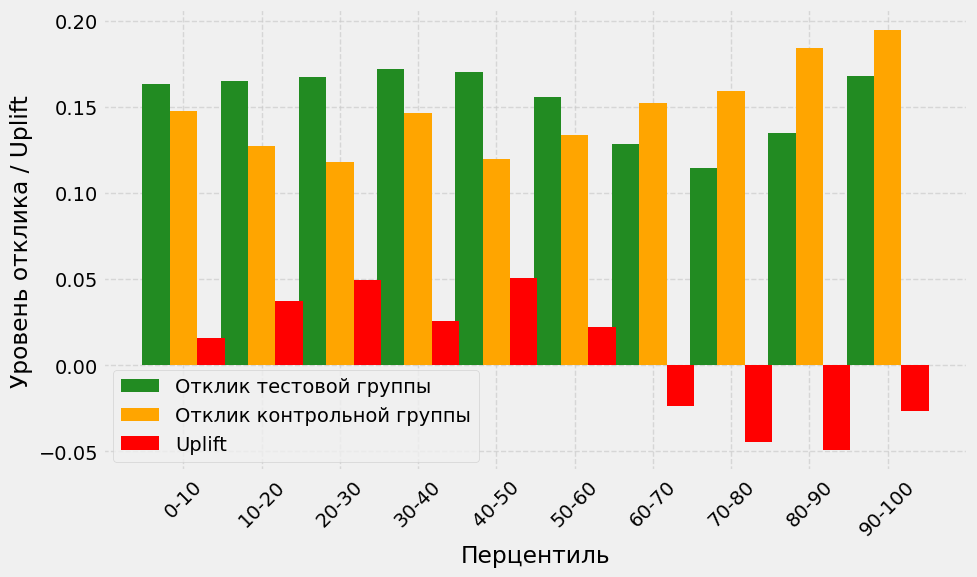

In [66]:
from utils import custom_uplift_by_percentile

fig = custom_uplift_by_percentile( 
    y_true=y_test.values,
    uplift=X_test_uplift['predicted_uplift'].values,
    treatment=X_test['treatment'].values,
    kind="bar"
)
fig.savefig("uplift_by_percentile.png", dpi=300, bbox_inches="tight")

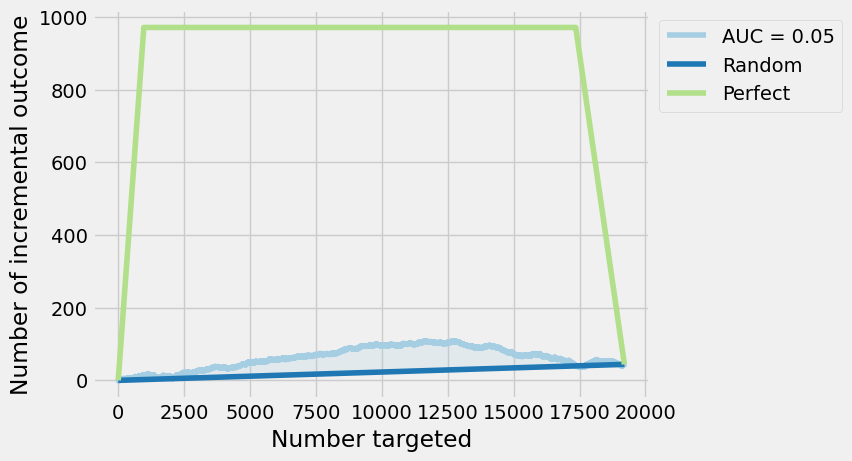

In [65]:
from sklift.viz import plot_qini_curve

display = plot_qini_curve(
    y_true=y_test.values,
    uplift=X_test_uplift['predicted_uplift'].values,
    treatment=X_test['treatment'].values,
    perfect=True,
    random=True
)

fig = display.ax_.figure  # access the underlying figure
fig.savefig("qini_curve.png", dpi=300, bbox_inches="tight")


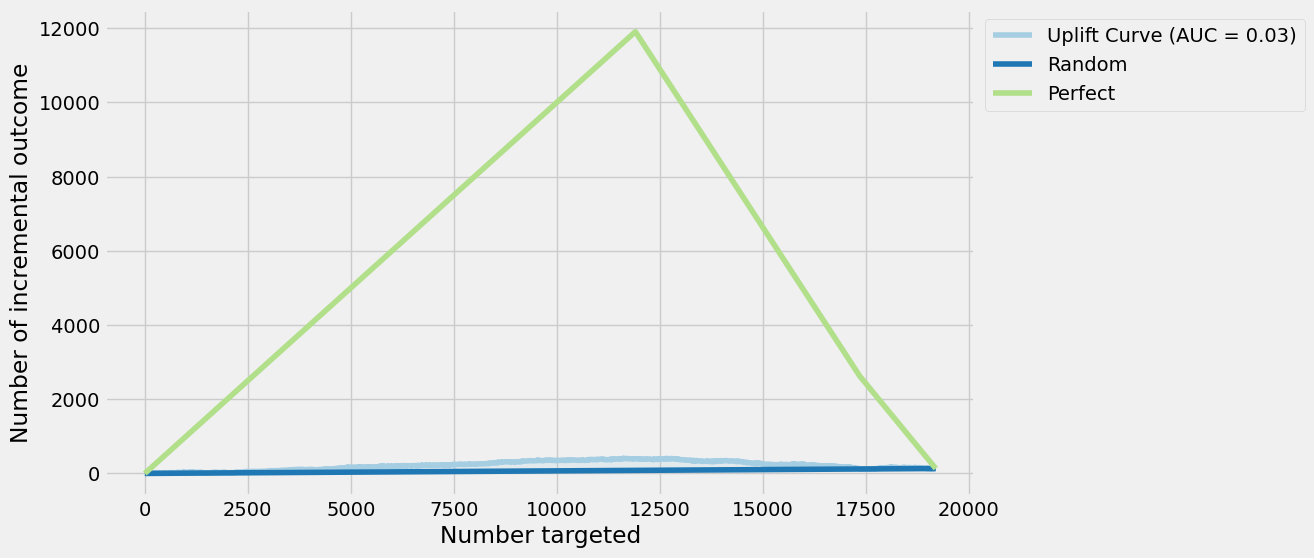

In [64]:
from sklift.viz import plot_uplift_curve
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 6))
display = plot_uplift_curve(
    y_true=y_test.values,
    uplift=X_test_uplift['predicted_uplift'].values,
    treatment=X_test['treatment'].values,
    perfect=True,
    ax=axs,
    name='Uplift Curve'
)
fig.savefig("uplift_curve.png", dpi=300, bbox_inches="tight")


#### 📌 Вывод по модели

**Что получилось хорошо**
- Модель совпадает по цели с бизнес-задачей: оптимизация **Uplift@30** позволяет найти верхние 20–30% аудитории с **положительным** приростом.
- На графике *uplift by percentile* первые перцентили дают явный плюс — есть сегменты, где контакт **стоит усиливать**.
- Выявлены и «красные зоны» (нижние перцентили) с отрицательным эффектом — их можно **смело исключать**, экономя бюджет.
- Построен полный контур измерения (Qini, Uplift Curve, uplift-by-percentile) — есть **надёжная базовая линия** для дальнейшего роста.

**Как улучшить дальше**
- Расширить и обогатить признаки (поведение, частота/давность, сезонность, канал контакта, взаимодействия признаков).
- Баланс цели: комбинировать **Uplift@30 + AUC(Qini)**, чтобы улучшать как топ‑30%, так и форму всей кривой.
- Регуляризация и калибровка uplift, контроль переобучения по сегментам; в проде — A/B с отсечением нижних.

**Итог**
- Модель уже даёт **практическую ценность**: помогает приоритизировать верхние сегменты и избегать вредных контактов.
- С текущей базой метрик и понятными следующими шагами ожидаем **быстрый прирост эффективности** при следующей итерации.

#### Логируем в Mlflow

In [ ]:
import mlflow.catboost
from mlflow.models.signature import infer_signature

RUN_NAME_CATBOOST = "uplift_best_model"
REGISTRY_MODEL_NAME = "uplift_best_model"

mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME_CATBOOST):
    # Логируем параметры модели
    mlflow.log_params(catboost_model.get_params())

    # Логируем uplift-метрики
    mlflow.log_metric("qini_auc", metrics["qini_auc"])
    mlflow.log_metric("uplift_auc", metrics["uplift_auc"])
    mlflow.log_metric("uplift_at_30", metrics["uplift_at_30"])

    mlflow.log_artifact("uplift_curve.png")
    mlflow.log_artifact("uplift_by_percentile.png")
    mlflow.log_artifact("qini_curve.png")


    # сигнатура для модели
    signature = infer_signature(X_test, catboost_model.predict(X_test))

    # Логируем модель в MLflow
    mlflow.catboost.log_model(
        cb_model=catboost_model,
        name="uplift_model",
        registered_model_name=REGISTRY_MODEL_NAME, 
        pip_requirements="./requirements.txt",
        signature=signature
    )

/Users/a.hrameev/miniconda3/envs/ya/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'uplift_best_model'.
2025/08/08 15:18:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: uplift_best_model, version 

🏃 View run uplift_best_model at: http://127.0.0.1:5000/#/experiments/34/runs/9487f39389a24591bc21f31aaa7c7013
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/34


# Этап 3

In [23]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        # Используем переданный список признаков, а не хардкодим
        self.feature_names = feature_names
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)

        # Здесь можно добавить преобразования, если они нужны для финальной модели
        # Например, если были категориальные признаки, one-hot-encoding и т.д.
        # Пока просто возвращаем X как есть

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        
        # Дополните код для получения предсказаний аплифта
        # Для CatBoostClassifier, обученного как uplift-модель, обычно делается так:
        # Предсказываем вероятность для treatment=1 и для treatment=0, разница - uplift

        # Создаем копии X с treatment=1 и treatment=0
        X_treat = X.copy()
        X_treat['treatment'] = 1
        X_control = X.copy()
        X_control['treatment'] = 0

        # Оставляем только нужные признаки + treatment
        features_for_model = self.feature_names + ['treatment']

        # Получаем вероятности для treatment=1 и treatment=0
        proba_treat = self.model.predict_proba(X_treat[features_for_model])[:, 1]
        proba_control = self.model.predict_proba(X_control[features_for_model])[:, 1]

        uplift = proba_treat - proba_control
        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [24]:
feature_names = [col for col in uplift_fp_data.columns if col not in ["target", "treatment"]]

model = UpliftModelInference(
    model=catboost_model,  
    feature_names=feature_names
)

In [25]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0]
        })

In [26]:
# проверка работы класса
model.predict(test_data)

array([-0.01447763, -0.00897689, -0.04328404])

# Все чтониже пришло в голову бонусом ) и интересно узнать верны ли размышоения

## Попоробуем Propensity Score и T-learner

- **Проблема:** если treatment назначался не случайно, возникает смещение — uplift-модель путает эффект воздействия с особенностями сегмента.
- **Propensity score** — вероятность попасть в treatment; по нему можно вычислить веса, чтобы сбалансировать группы.
- **T-learner** — обучает две отдельные модели для treated и control, а uplift берётся как разница их прогнозов.

**Плюсы связки:**
- Убирает смещение от нерандомного назначения.
- Моделирует разные зависимости в treated и control.
- Даёт более честную и устойчивую оценку uplift.

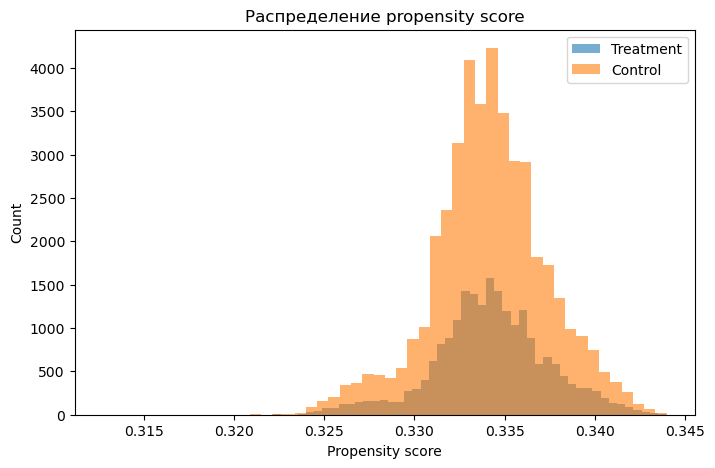

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Отбираем фичи, убирая колонки treatment и target
X = uplift_fp_data.drop(columns=['treatment', 'target'])
y_treat = uplift_fp_data['treatment']

# Считаем propensity score
prop_model = LogisticRegression(max_iter=500)
prop_model.fit(X, y_treat)
X['propensity_score'] = prop_model.predict_proba(X)[:, 1]

# Рисуем распределения
plt.figure(figsize=(8, 5))
plt.hist(X.loc[uplift_fp_data.treatment == 1, 'propensity_score'], bins=50, alpha=0.6, label='Treatment')
plt.hist(X.loc[uplift_fp_data.treatment == 0, 'propensity_score'], bins=50, alpha=0.6, label='Control')
plt.xlabel('Propensity score')
plt.ylabel('Count')
plt.title('Распределение propensity score')
plt.legend()
plt.show()

✅ **Вывод по анализу propensity score**

Видно, что распределения **`propensity_score`** для **`treatment`** и **`control`**  
заметно различаются — значит, назначение *treatment* в этих данных  
**не было полностью случайным**.

📌 Что это значит
- У некоторых сегментов вероятность попасть в treatment **значительно выше**, чем у других.
- Если не скорректировать это смещение, uplift-модель может путать:  
  **эффект воздействия** ↔ **эффект того, что сегмент просто чаще таргетили**.

💡 *Рекомендация:* учесть bias через **IPW** 

In [19]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression

class PropensityIPWTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, treatment_col='treatment', target_col='target', max_iter=500):
        self.treatment_col = treatment_col
        self.target_col = target_col
        self.max_iter = max_iter
        self.model = None

    def fit(self, X, y=None):
        # Обучаем логистическую регрессию для propensity score
        feats = X.drop(columns=[self.treatment_col, self.target_col])
        y_treat = X[self.treatment_col]
        self.model = LogisticRegression(max_iter=self.max_iter)
        self.model.fit(feats, y_treat)
        return self

    def transform(self, X):
        X_out = X.copy()
        feats = X_out.drop(columns=[self.treatment_col, self.target_col])
        # Пропенсити скор
        X_out['propensity_score'] = self.model.predict_proba(feats)[:, 1]
        # IPW веса
        X_out['ipw'] = np.where(
            X_out[self.treatment_col] == 1,
            1.0 / X_out['propensity_score'],
            1.0 / (1.0 - X_out['propensity_score'])
        )
        return X_out

In [20]:
transformer = PropensityIPWTransformer()
df_with_scores = transformer.fit_transform(uplift_fp_data)
df_with_scores

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target,propensity_score,ipw
0,10,1,142.44,1,0,1,0,1,1,0,0.334595,2.988688
1,6,2,329.08,1,1,2,1,2,0,0,0.326251,1.484232
2,7,1,180.65,0,1,1,1,2,1,0,0.334993,2.985137
3,9,4,675.83,1,0,2,1,2,0,0,0.336494,1.507145
4,2,0,45.34,1,0,0,0,2,1,0,0.329735,3.032739
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,1,105.54,1,0,0,0,2,0,0,0.332885,1.498991
63996,5,0,38.91,0,1,0,1,1,0,0,0.335219,1.504255
63997,6,0,29.99,1,0,0,1,1,0,0,0.333626,1.500658
63998,1,4,552.94,1,0,1,1,0,1,0,0.339650,2.944210


In [48]:
from sklearn.model_selection import train_test_split

# Разделим данные на признаки и целевую переменную
X = df_with_scores.drop('target', axis=1)
y = df_with_scores['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=df_with_scores[['target', 'treatment']]
)

In [49]:
from causalml.inference.meta import BaseTClassifier
from sklearn.ensemble import RandomForestClassifier

# создаём базовые модели для тестовой и контрольной групп 
treatment_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

control_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=RANDOM_STATE,
    class_weight='balanced',
)

# инициализируем T-learner
t_learner = BaseTClassifier(
    treatment_learner=treatment_model,
    control_learner=control_model,
    control_name=0,  # название контрольной группы в столбце treatment
)

# обучаем T-learner
t_learner.fit(
    X=X_train.values,  # Признаки без столбца treatment
    treatment=X_train['treatment'].values,       # Столбец с признаком воздействия
    y=y_train.values                            # Целевая переменная
)

In [50]:
uplift_pred = t_learner.predict(X_test.values)

metrics = evaluate_uplift_metrics(
    y_true=y_test.values,
    uplift_vals=uplift_pred.squeeze(),
    treatment=X_test['treatment'].values,
    k=0.3
)

for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

qini_auc: 0.1769
uplift_auc: 0.0499
uplift_at_30: 0.0790


#### 📊 Базовый T-learner vs Propensity Score (IPW)

| Метрика        | Базовый T-learner | PS (IPW)  | Δ (PS − T-learner) |
|:--------------:|:-----------------:|:---------:|:------------------:|
| **Qini AUC**   | 0.0607             | 0.1769    | +0.1162            |
| **Uplift AUC** | 0.0269             | 0.0499    | +0.0230            |
| **Uplift@30%** | 0.0328             | 0.0790    | +0.0462            |

📌 **Вывод:** добавление Propensity Score с IPW дало большой прирост по всем метрикам  
по сравнению с базовым T-learner, что подтверждает наличие значительного смещения в данных  
и пользу его корректировки.

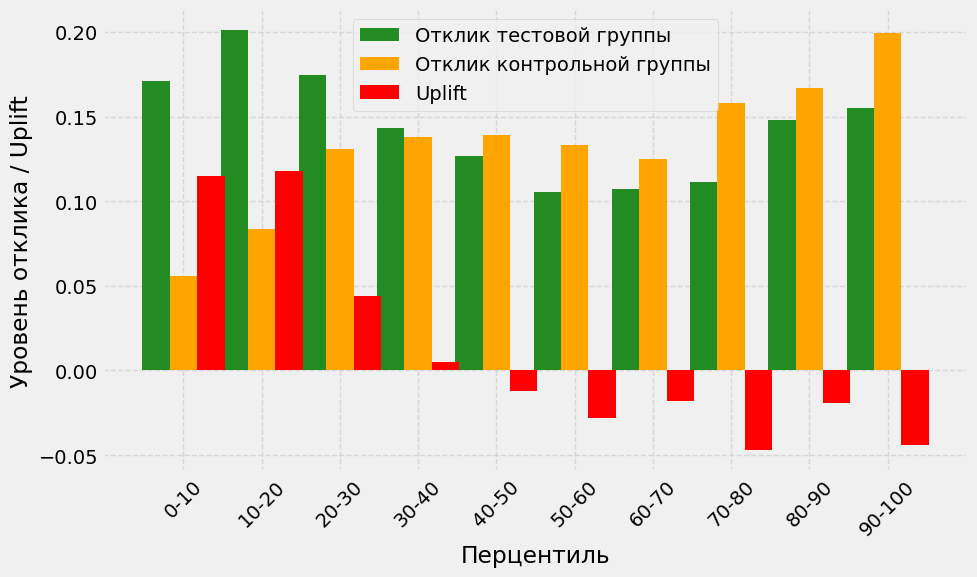

In [63]:
from utils import custom_uplift_by_percentile

fig = custom_uplift_by_percentile( 
    y_true=y_test.values,
    uplift=uplift_pred.ravel() ,
    treatment=X_test['treatment'].values,
    kind="bar"
)

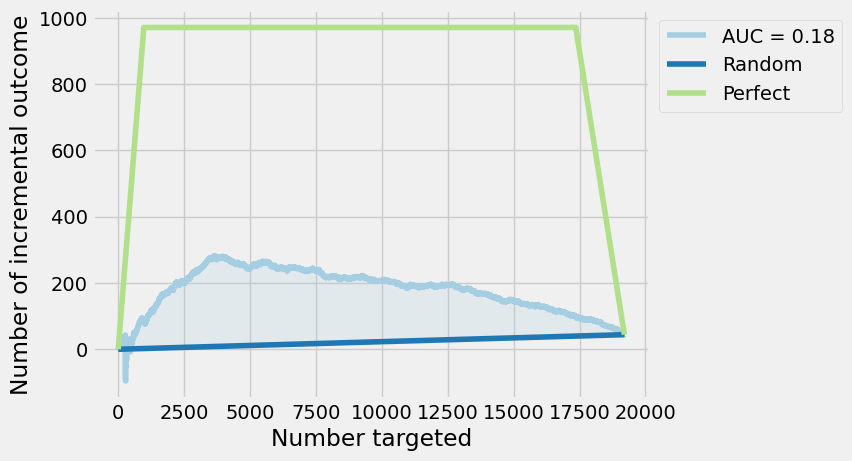

In [68]:
from sklift.viz import plot_qini_curve

display = plot_qini_curve(
    y_true=y_test.values,
    uplift=uplift_pred.ravel() ,
    treatment=X_test['treatment'].values,
    perfect=True,
    random=True
)

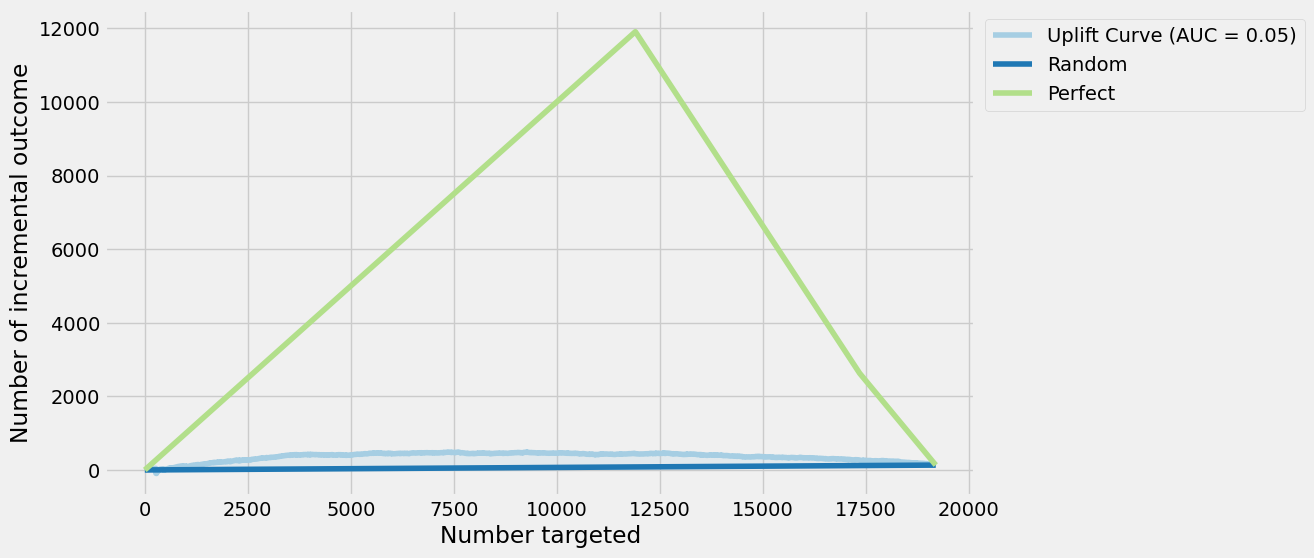

In [70]:
from sklift.viz import plot_uplift_curve
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 6))
display = plot_uplift_curve(
    y_true=y_test.values,
    uplift=uplift_pred.ravel() ,
    treatment=X_test['treatment'].values,
    perfect=True,
    ax=axs,
    name='Uplift Curve'
)